# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

#H = np.load('Hamiltonian_Example.npy')
# I have -2.0 < u 2.0 in steps of 0.1
u=4.0
t=-1
H = np.load('H_mu_'+str(u)+"_t_"+str(t)+'.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-2.10274848e+00, -1.80642385e+00, -1.06814039e+00, -8.28427125e-01,
       -8.28427125e-01,  8.70432672e-16,  5.81449281e-01,  2.00000000e+00,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.38787313e+00,
        2.96539191e+00,  3.17157288e+00,  3.17157288e+00,  4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  4.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  4.82842712e+00,  4.82842712e+00,  5.03460809e+00,
        5.61212687e+00,  6.00000000e+00,  6.00000000e+00,  6.00000000e+00,
        6.00000000e+00,  7.41855072e+00,  8.00000000e+00,  8.82842712e+00,
        8.82842712e+00,  9.06814039e+00,  9.80642385e+00,  1.01027485e+01])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [3]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [4]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [5]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,8.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,4.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,4.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [6]:
print(blocks['0,0'])

SummedOp([
  5.5 * III,
  -0.5 * IIX,
  IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -1.5 * IZI,
  -0.5 * IZX,
  IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -0.5 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [7]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-7-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-7-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [8]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,8,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,4,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,4,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,4,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,4,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,4,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,4,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,8,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [9]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

(-2.1027484834620758+0j)
-2.1027484834620758


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [11]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


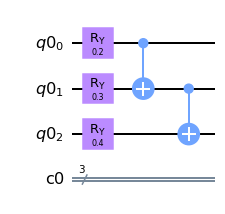

In [12]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [13]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


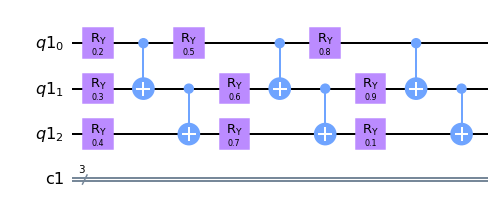

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [15]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

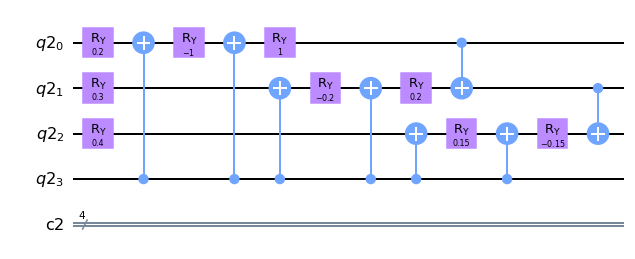

In [16]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [17]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [18]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

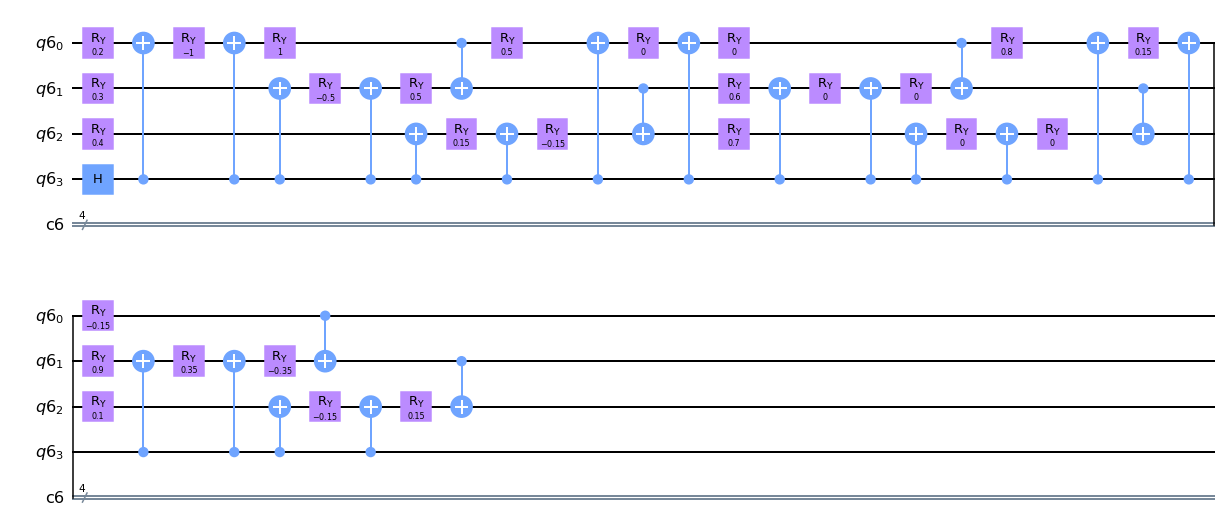

In [19]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [20]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.7209464513295367+0j)
0.7209464513295365
0.697265625


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [21]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (8.203356243660826+0j)
simple: (8.203356243660826+0j)
matrix: 8.203356243660826
simulator: 8.3251953125


In [22]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.7798723201234657+0j)
simple: (-0.7798723201234659+0j)
matrix: -0.7798723201234659
simulator: -0.787109375


Now we need to add all of the blocks together

In [23]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E
            
find_E(alpha,phi,blocks)

(3.7742942963566093+0j)

In [24]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(3.7742942963566093+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [25]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(2.666666666666668+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [26]:
import copy

In [41]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    np.random.seed(10)
    
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [45]:
out = SPSA(3000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 3.743617220574344 E_A= (6.020770829118117+0j) E_B= (3.025877052658642+0j) E_f= 2.2328118410407867
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -1.2400638324778075 E_A= (3.5929170284916117+0j) E_B= (4.517892036268712+0j) E_f= 2.152708079429086
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 3.770674877821389 E_A= (5.4652981326359305+0j) E_B= (2.7655712706810913+0j) E_f= 1.990553478830129
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= -1.120092949990822 E_A= (3.4128258854566496+0j) E_B= (4.191823255752414+0j) E_f= 2.0199877273853293
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 1.1124090503222177 E_A= (3.120225792244221+0j) E_B= (2.363813583150196+0j) E_f= 1.8756030326690145
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= -1.802446992470609 E_A= (3.3647832527893917+0j) E_B= (4.568042511898656+0j) E_f= 1.9713850656485126
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095918097278 g= 0.1826644296

k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= -4.0045219807688035 E_A= (1.1080183325493254+0j) E_B= (3.2533221521741966+0j) E_f= -0.013415647925206747
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= 1.0530578715392351 E_A= (2.2525507559494224+0j) E_B= (1.689470296828695+0j) E_f= 0.04201046839598255
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= 3.3627297440958372 E_A= (2.601258256366593+0j) E_B= (0.8065026415211982+0j) E_f= -0.036799590932564144
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= 2.279246742080391 E_A= (2.398248816688427+0j) E_B= (1.18398140691744+0j) E_f= -0.06708831058594245
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= -3.312569253493248 E_A= (0.87014356259209+0j) E_B= (2.6317609698526807+0j) E_f= -0.11924871021943098
k= 57 c_k= 0.26543229614067565 a_k= 0.021410938936572577 g= -0.7737627070270475 E_A= (1.1853653155756816+0j) E_B= (1.5961285395641098+0j) E_f= -0.08093894365041054
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.019298881045265278 g= -2.534594674565577 E_A= (0.9293802285842734+0j) E_B= (2.197844204183315+0j) E_f= -0.24009234245362687
k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= 0.20611461621496593 E_A= (1.5647651968526088+0j) E_B= (1.461712667001883+0j) E_f= -0.2294992004465784
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= 4.651377488820367 E_A= (2.277683599216669+0j) E_B= (-0.045671977727394536+0j) E_f= -0.3604219669371679
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= 2.408166719705304 E_A= (2.4255166547311733+0j) E_B= (1.223781472912994+0j) E_f= -0.2170940493292238
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= 3.9127883986078356 E_A= (2.2939916659662787+0j) E_B= (0.3432464531293513+0j) E_f= -0.3063067941455439
k= 108 c_k= 0.24904619740500722 a_k= 0.01913308782851349 g= -2.378412216285042 E_A= (0.4087680168333929+0j) E_B= (1.5934370534882034+0j) E_f= -0.3226579730965566
k= 109 c_k= 0.2488165878742

k= 154 c_k= 0.24034577371294386 a_k= 0.017916605514221893 g= -0.9134584071011238 E_A= (1.0165534041936455+0j) E_B= (1.4556451394122711+0j) E_f= -0.3799355875529271
k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= 3.446792282853906 E_A= (2.0009937445498727+0j) E_B= (0.34522563216682944+0j) E_f= -0.44746528915457473
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= 2.448935400869612 E_A= (1.7401042002479064+0j) E_B= (0.5644449877269018+0j) E_f= -0.3934816339023443
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= 1.1530860441174546 E_A= (1.5102830593104724+0j) E_B= (0.9570764793232659+0j) E_f= -0.40473391477932513
k= 158 c_k= 0.239728066017013 a_k= 0.01783055152347874 g= 1.9303281141865094 E_A= (1.4001527553427324+0j) E_B= (0.47464510415833294+0j) E_f= -0.4636956860617355
k= 159 c_k= 0.23957631084767136 a_k= 0.01780941980024826 g= -1.6241066130784627 E_A= (0.35118005704063376+0j) E_B= (1.1293749986099229+0j) E_f= -0.4762340695444713
k= 160 c_k= 0.23942559

k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= -0.6404137607960056 E_A= (1.2544465420114395+0j) E_B= (1.553569710808218+0j) E_f= -0.3986898590660497
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= -1.254858468142545 E_A= (0.5713786825937018+0j) E_B= (1.1572088444490958+0j) E_f= -0.3666701467950543
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= -0.1178780204872722 E_A= (1.2409693283166006+0j) E_B= (1.295973854041566+0j) E_f= -0.3725591119366033
k= 208 c_k= 0.2331982121051757 a_k= 0.016925469995779104 g= 1.8077383726364855 E_A= (1.8613538807818748+0j) E_B= (1.0182311678763782+0j) E_f= -0.4092411667389652
k= 209 c_k= 0.23308581407379206 a_k= 0.016909978113415238 g= -0.11733273540122267 E_A= (1.0394088530892462+0j) E_B= (1.094106045386244+0j) E_f= -0.41043448708043884
k= 210 c_k= 0.232974003790588 a_k= 0.01689457057268661 g= 3.064432549556381 E_A= (1.9707181716091635+0j) E_B= (0.5428519307764644+0j) E_f= -0.4405346103075246
k= 211 c_k= 0.23286277541

k= 256 c_k= 0.22837930441497245 a_k= 0.01626451962299262 g= -0.993926473108074 E_A= (0.8951185150978673+0j) E_B= (1.349102988233965+0j) E_f= -0.7729187817604491
k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= -0.3040251533012863 E_A= (1.0147014735015416+0j) E_B= (1.1535131223142407+0j) E_f= -0.7820222706678057
k= 258 c_k= 0.22820056489801344 a_k= 0.01624014101894129 g= -0.534881938569551 E_A= (0.6693146160463617+0j) E_B= (0.9134353371169938+0j) E_f= -0.7681587062980272
k= 259 c_k= 0.22811176412405826 a_k= 0.01622803320780049 g= -2.841726302250318 E_A= (0.2617030991101663+0j) E_B= (1.55816549903828+0j) E_f= -0.7184941349459708
k= 260 c_k= 0.22802333859359442 a_k= 0.016215979134588294 g= -1.5646330397806556 E_A= (0.39634430732162734+0j) E_B= (1.1098900061308858+0j) E_f= -0.7076875963400211
k= 261 c_k= 0.22793528529233112 a_k= 0.016203978363821238 g= 2.348749707610303 E_A= (1.7543535051321182+0j) E_B= (0.6836276357632508+0j) E_f= -0.6601123653395967
k= 262 c_k= 0.227847601241

k= 307 c_k= 0.2242416957476633 a_k= 0.015702982735919514 g= -1.865102133244937 E_A= (0.09650104502700127+0j) E_B= (0.9329683752298592+0j) E_f= -0.6809940481446378
k= 308 c_k= 0.22416829307647623 a_k= 0.015693075965474278 g= 1.613664280970574 E_A= (1.0196883264932948+0j) E_B= (0.2962235915659889+0j) E_f= -0.647757360643132
k= 309 c_k= 0.22409515148215373 a_k= 0.015683206422906985 g= -1.200054165415197 E_A= (-0.09645653518646148+0j) E_B= (0.4413961047845548+0j) E_f= -0.6743242983525983
k= 310 c_k= 0.2240222691984007 a_k= 0.01567337385263873 g= 1.9435762531092498 E_A= (1.0626815537872125+0j) E_B= (0.19187282862389377+0j) E_f= -0.743390755566115
k= 311 c_k= 0.2239496444765029 a_k= 0.015663578001634454 g= 0.6557381201342856 E_A= (1.1737085712893711+0j) E_B= (0.8800039335418439+0j) E_f= -0.7517801010944485
k= 312 c_k= 0.22387727558509607 a_k= 0.015653818619369854 g= -2.7590436724737804 E_A= (0.0932995556187117+0j) E_B= (1.3286739168461679+0j) E_f= -0.8385164484737104
k= 313 c_k= 0.2238051608

k= 358 c_k= 0.22079816106773162 a_k= 0.015240446991449733 g= 2.324339872562815 E_A= (1.224078702888384+0j) E_B= (0.19765876377183333+0j) E_f= -0.7335549122667182
k= 359 c_k= 0.22073613743405993 a_k= 0.015232158767708136 g= -0.7581567979229021 E_A= (0.4483930069075293+0j) E_B= (0.7830982131932823+0j) E_f= -0.7511172674312985
k= 360 c_k= 0.22067430319994108 a_k= 0.015223897403529201 g= 0.10267883080741443 E_A= (0.4345692674634663+0j) E_B= (0.38925210857984466+0j) E_f= -0.7513131114318001
k= 361 c_k= 0.2206126572647566 a_k= 0.015215662739822751 g= 2.712713011918219 E_A= (1.226124889018672+0j) E_B= (0.02920723710675298+0j) E_f= -0.7411362968476272
k= 362 c_k= 0.2205511985373019 a_k= 0.015207454618865354 g= 0.4415853052816332 E_A= (0.6693722029041858+0j) E_B= (0.47458786623153665+0j) E_f= -0.7467491941956904
k= 363 c_k= 0.22048992593568012 a_k= 0.015199272884284947 g= 3.162560582566595 E_A= (1.5055702516574765+0j) E_B= (0.11094475442305657+0j) E_f= -0.7499413617525013
k= 364 c_k= 0.22042883

k= 409 c_k= 0.21785564705344662 a_k= 0.014848989391098043 g= -2.0280192352301576 E_A= (0.29438344794808635+0j) E_B= (1.1780143334038904+0j) E_f= -0.8141852331034539
k= 410 c_k= 0.2178020521092889 a_k= 0.014841893231637726 g= -1.6400459004025885 E_A= (0.13382151970852318+0j) E_B= (0.8482322450307436+0j) E_f= -0.7850372846735585
k= 411 c_k= 0.21774860054507708 a_k= 0.01483481728679895 g= 0.864285101558036 E_A= (0.8158849300715654+0j) E_B= (0.4394911873991211+0j) E_f= -0.7514479249464106
k= 412 c_k= 0.21769529163061768 a_k= 0.014827761451299215 g= -2.808684597570538 E_A= (-0.01596540458039622+0j) E_B= (1.2069094205526882+0j) E_f= -0.8449572648431342
k= 413 c_k= 0.21764212464119265 a_k= 0.014820725620651613 g= -3.534489660659573 E_A= (-0.013491271360741741+0j) E_B= (1.5250164071758132+0j) E_f= -0.8277962810804815
k= 414 c_k= 0.217589098857505 a_k= 0.014813709691156947 g= -1.3235761387639617 E_A= (0.33908996722701334+0j) E_B= (0.9150814458329062+0j) E_f= -0.841877659023605
k= 415 c_k= 0.217

k= 460 c_k= 0.21529116004852789 a_k= 0.014510848303116568 g= 0.15088852998828972 E_A= (0.6794950943393421+0j) E_B= (0.6145251610209501+0j) E_f= -0.939419570140071
k= 461 c_k= 0.2152440483769229 a_k= 0.014504663658363552 g= -3.2841746329955996 E_A= (-0.4593075973015645+0j) E_B= (0.9544904898639713+0j) E_f= -0.9505765896816314
k= 462 c_k= 0.21519704884440038 a_k= 0.014498494730401415 g= 3.0763661942997085 E_A= (0.6919522433062208+0j) E_B= (-0.6320976090497322+0j) E_f= -1.0815734485745483
k= 463 c_k= 0.21515016094269962 a_k= 0.01449234144618824 g= 0.6863748352206983 E_A= (0.26108181448955603+0j) E_B= (-0.034265498039948314+0j) E_f= -1.0871233595296654
k= 464 c_k= 0.21510338416695282 a_k= 0.014486203733174744 g= -1.9881364187302686 E_A= (-0.3944434716967282+0j) E_B= (0.4608662720121652+0j) E_f= -1.0736643852922907
k= 465 c_k= 0.215056718015655 a_k= 0.014480081519299942 g= -0.42356559396078725 E_A= (0.15953241187271378+0j) E_B= (0.34171366487583066+0j) E_f= -1.0679102660144466
k= 466 c_k= 0

k= 510 c_k= 0.21306370776935854 a_k= 0.01421954244559556 g= 1.5107405309567128 E_A= (0.4728261958330807+0j) E_B= (-0.17094176217309248+0j) E_f= -0.9052671810446941
k= 511 c_k= 0.21302164067868354 a_k= 0.014214062909299498 g= -1.29731511843806 E_A= (0.45489072283677284+0j) E_B= (1.0076031128506453+0j) E_f= -0.8950831532436362
k= 512 c_k= 0.21297966395158172 a_k= 0.014208595965656191 g= 2.052735498420378 E_A= (0.7271447720153231+0j) E_B= (-0.14723706125478642+0j) E_f= -0.9117782823273097
k= 513 c_k= 0.21293777721836393 a_k= 0.014203141561731296 g= 4.174568886037509 E_A= (1.2711499645731728+0j) E_B= (-0.506696874302365+0j) E_f= -0.992252237709757
k= 514 c_k= 0.21289598011156907 a_k= 0.014197699644913457 g= 0.25755881383688706 E_A= (0.1497157525957502+0j) E_B= (0.04004928037939576+0j) E_f= -0.9955646524818142
k= 515 c_k= 0.2128542722659462 a_k= 0.014192270162911738 g= 0.2560320360326326 E_A= (0.09940284259474577+0j) E_B= (-0.009592182818243256+0j) E_f= -0.989946055622825
k= 516 c_k= 0.2128

k= 560 c_k= 0.21106428084828605 a_k= 0.013960023410284367 g= 1.0342395512350517 E_A= (0.6481365766252898+0j) E_B= (0.21155452241272915+0j) E_f= -1.0169586289369053
k= 561 c_k= 0.2110263189945575 a_k= 0.013955114447831835 g= -3.582158259062421 E_A= (-0.4396548500077304+0j) E_B= (1.0722044929240602+0j) E_f= -1.0093409275802256
k= 562 c_k= 0.21098843143819737 a_k= 0.013950215781679329 g= -1.7455804219117927 E_A= (-0.3469966996919063+0j) E_B= (0.38959785064488556+0j) E_f= -1.0237070724059927
k= 563 c_k= 0.21095061790221384 a_k= 0.013945327372318217 g= -0.9981766226071196 E_A= (0.20233894376633071+0j) E_B= (0.6234708943953643+0j) E_f= -0.9972396435793442
k= 564 c_k= 0.21091287811113657 a_k= 0.013940449180459964 g= 2.264297398022992 E_A= (0.9212722469831097+0j) E_B= (-0.03386671525006428+0j) E_f= -0.9799931257873685
k= 565 c_k= 0.21087521179100568 a_k= 0.013935581167034524 g= -1.9931315469979156 E_A= (-0.3162998466050739+0j) E_B= (0.5243042275959667+0j) E_f= -1.0409091982267114
k= 566 c_k= 0

k= 610 c_k= 0.20925210189794397 a_k= 0.013726461386285766 g= -1.4951398228936077 E_A= (-0.224352126888137+0j) E_B= (0.40137017425547716+0j) E_f= -1.101117785324237
k= 611 c_k= 0.20921754307254326 a_k= 0.013722022813102922 g= 1.4181869306204038 E_A= (0.4680178141152358+0j) E_B= (-0.1254013563687487+0j) E_f= -1.114733763362941
k= 612 c_k= 0.20918304636329907 a_k= 0.01371759280195691 g= 0.4858049107428 E_A= (-0.14307968289888273+0j) E_B= (-0.34632398523374175+0j) E_f= -1.1125893003541905
k= 613 c_k= 0.209148611557505 a_k= 0.013713171322627967 g= -0.4581137133181188 E_A= (0.0042003764615383965+0j) E_B= (0.19582807061341326+0j) E_f= -1.1002069622510517
k= 614 c_k= 0.20911423844352794 a_k= 0.013708758345051218 g= 1.3874413392263742 E_A= (0.7004564691438264+0j) E_B= (0.12018899106904289+0j) E_f= -1.064534136092725
k= 615 c_k= 0.20907992681080098 a_k= 0.013704353839315616 g= -1.931270372350336 E_A= (-0.8056646633968569+0j) E_B= (0.0019150728088962038+0j) E_f= -1.0986676038756507
k= 616 c_k= 0.

k= 660 c_k= 0.2075963167916528 a_k= 0.013514462507899616 g= 0.8743212115968907 E_A= (0.09823013434081897+0j) E_B= (-0.2647815920998407+0j) E_f= -1.2756815253141662
k= 661 c_k= 0.20756462271546675 a_k= 0.013510417830378152 g= -0.30539184990590046 E_A= (-0.44933330804865196+0j) E_B= (-0.3225562198364586+0j) E_f= -1.2721208826503112
k= 662 c_k= 0.2075329813072515 a_k= 0.013506380375062556 g= -1.4598911325187305 E_A= (-0.39114253885336864+0j) E_B= (0.21480857937789524+0j) E_f= -1.274135260102113
k= 663 c_k= 0.20750139240024437 a_k= 0.013502350118354147 g= -1.1026399422753534 E_A= (-0.3938344221950925+0j) E_B= (0.06376422448142938+0j) E_f= -1.2611324080766138
k= 664 c_k= 0.20746985582846092 a_k= 0.013498327036766226 g= -2.3135172930262398 E_A= (-0.3330291585619387+0j) E_B= (0.6269410399196716+0j) E_f= -1.247385517035259
k= 665 c_k= 0.2074383714266899 a_k= 0.013494311106923366 g= 1.7063005335155024 E_A= (0.40859549108815757+0j) E_B= (-0.29930891658573827+0j) E_f= -1.226043286480376
k= 666 c_

k= 710 c_k= 0.20607303230196078 a_k= 0.01332063769323634 g= 2.507963704481385 E_A= (0.5579188747817241+0j) E_B= (-0.47572849618975127+0j) E_f= -1.2756175334801247
k= 711 c_k= 0.2060437815605819 a_k= 0.013316927262620532 g= 0.9161114907874107 E_A= (-0.05504482251569312+0j) E_B= (-0.43256297430157364+0j) E_f= -1.274955049392991
k= 712 c_k= 0.20601457601610662 a_k= 0.013313222998937106 g= 0.6756526800549121 E_A= (0.15844469565635283+0j) E_B= (-0.11994390517496488+0j) E_f= -1.2724912690936656
k= 713 c_k= 0.20598541553545574 a_k= 0.013309524883427886 g= -0.7953165462061267 E_A= (-0.23432207624670426+0j) E_B= (0.09332514225828076+0j) E_f= -1.2629105080710494
k= 714 c_k= 0.20595629998612755 a_k= 0.013305832897417564 g= -1.150069056422664 E_A= (-0.7813399746093472+0j) E_B= (-0.3076120394306496+0j) E_f= -1.2746090902621772
k= 715 c_k= 0.2059272292361946 a_k= 0.013302147022313223 g= -1.3878132122368072 E_A= (-0.13922957287963128+0j) E_B= (0.4323474861069858+0j) E_f= -1.2849423224272551
k= 716 c_

k= 760 c_k= 0.20466337943631244 a_k= 0.013142321113793145 g= -0.04782664762257491 E_A= (0.14721274031950987+0j) E_B= (0.16678946697860159+0j) E_f= -1.2147301369401962
k= 761 c_k= 0.20463623612242432 a_k= 0.013138897571560183 g= -0.07020892851732548 E_A= (-0.14959787986633533+0j) E_B= (-0.12086329811838767+0j) E_f= -1.2150132581086257
k= 762 c_k= 0.20460913199911662 a_k= 0.013135479351191795 g= 1.992441607544169 E_A= (0.1457765891155745+0j) E_B= (-0.6695669066414995+0j) E_f= -1.2135211056677195
k= 763 c_k= 0.20458206695855174 a_k= 0.013132066437546538 g= -0.9321294951779828 E_A= (-0.28466499687958197+0j) E_B= (0.09672896071350431+0j) E_f= -1.2125940475179848
k= 764 c_k= 0.20455504089332952 a_k= 0.013128658815545544 g= -1.2197375453352979 E_A= (-0.4896910782246889+0j) E_B= (0.00931584870569356+0j) E_f= -1.211575617203863
k= 765 c_k= 0.20452805369648472 a_k= 0.01312525647017217 g= 0.6056539919569198 E_A= (0.038149323322490096+0j) E_B= (-0.20959714105442037+0j) E_f= -1.2133424035016418
k= 

k= 810 c_k= 0.2033522045880871 a_k= 0.01297738024040563 g= 0.8958246223372092 E_A= (0.03273759685236009+0j) E_B= (-0.3315982269007639+0j) E_f= -1.2473996242613408
k= 811 c_k= 0.20332689676653345 a_k= 0.0129742053960167 g= 1.9328744275265808 E_A= (0.20935272051566867+0j) E_B= (-0.5766579978610704+0j) E_f= -1.2407006891500334
k= 812 c_k= 0.2033016232369016 a_k= 0.012971035186914202 g= 0.33096406014766583 E_A= (-0.23580477398374455+0j) E_B= (-0.37037583530593654+0j) E_f= -1.237896689677117
k= 813 c_k= 0.20327638391063232 a_k= 0.012967869600710736 g= 0.4659633396804011 E_A= (0.030009787665568388+0j) E_B= (-0.1594288977847388+0j) E_f= -1.2340234059132038
k= 814 c_k= 0.20325117869950363 a_k= 0.012964708625066993 g= -0.6611024158961244 E_A= (-0.01848159867158105+0j) E_B= (0.2502580918723724+0j) E_f= -1.2365637730589867
k= 815 c_k= 0.203226007515629 a_k= 0.012961552247691495 g= 1.3028792981796247 E_A= (-0.08024080588966227+0j) E_B= (-0.609798721977282+0j) E_f= -1.2196825418383581
k= 816 c_k= 0

k= 860 c_k= 0.2021271595682987 a_k= 0.012824084033043217 g= 0.7586007259951946 E_A= (-0.039715713356151636+0j) E_B= (-0.3463833333398675+0j) E_f= -1.259470591845505
k= 861 c_k= 0.20210346409672147 a_k= 0.012821126667642437 g= -0.6928115745609696 E_A= (-0.613702691465313+0j) E_B= (-0.333663453095161+0j) E_f= -1.2614923675836704
k= 862 c_k= 0.2020797988711643 a_k= 0.012818173372599776 g= 0.7105922840500841 E_A= (-0.297537493214239+0j) E_B= (-0.5847301848947235+0j) E_f= -1.2656618419151482
k= 863 c_k= 0.20205616381803929 a_k= 0.012815224137660137 g= 0.9805040224354985 E_A= (0.02488401674566257+0j) E_B= (-0.37134974601728454+0j) E_f= -1.2682458077077121
k= 864 c_k= 0.20203255886402235 a_k= 0.012812278952605949 g= -1.222262522842669 E_A= (-0.6752111332252462+0j) E_B= (-0.18133748303824623+0j) E_f= -1.262043472561286
k= 865 c_k= 0.20200898393605224 a_k= 0.012809337807257 g= -0.0011392839908901467 E_A= (0.04711910770559265+0j) E_B= (0.047579398908421305+0j) E_f= -1.262049345065436
k= 866 c_k=

k= 910 c_k= 0.2009780532897974 a_k= 0.012681009230351935 g= -1.0358285496984365 E_A= (-0.4699390711270757+0j) E_B= (-0.05358146020630386+0j) E_f= -1.3318620214665453
k= 911 c_k= 0.2009557848741722 a_k= 0.012678243516688253 g= -1.24823877288222 E_A= (-0.7684628540612171+0j) E_B= (-0.2667812494313768+0j) E_f= -1.3319236136025046
k= 912 c_k= 0.20093354332558636 a_k= 0.01267548140330734 g= 0.37561754326538743 E_A= (-0.5393799032091664+0j) E_B= (-0.6903282310162985+0j) E_f= -1.3333493438454718
k= 913 c_k= 0.20091132858225064 a_k= 0.012672722881629486 g= -0.8146908336023935 E_A= (-0.6221799525892618+0j) E_B= (-0.29481871706358553+0j) E_f= -1.3252621597628553
k= 914 c_k= 0.20088914058258517 a_k= 0.012669967943104682 g= -0.396610971019267 E_A= (-0.4415039266320699+0j) E_B= (-0.2821542524046996+0j) E_f= -1.3193200276118469
k= 915 c_k= 0.20086697926521874 a_k= 0.012667216579212492 g= -1.6030271992710803 E_A= (-0.7378030799503498+0j) E_B= (-0.09381261755521814+0j) E_f= -1.3305645384256488
k= 916 

k= 960 c_k= 0.1998963799028756 a_k= 0.012546972297810748 g= 0.4262608391657821 E_A= (-0.2883975832978987+0j) E_B= (-0.4588135805851022+0j) E_f= -1.3698416830367626
k= 961 c_k= 0.19987538304813793 a_k= 0.012544376640804072 g= 1.5096185873714736 E_A= (-0.25579656204278023+0j) E_B= (-0.8592677488577046+0j) E_f= -1.3744507034775078
k= 962 c_k= 0.19985441021036454 a_k= 0.012541784189002975 g= 0.9889557166512999 E_A= (-0.11668131349994144+0j) E_B= (-0.5119756364509693+0j) E_f= -1.3644182046039497
k= 963 c_k= 0.19983346133718707 a_k= 0.012539194935161507 g= 0.13434544341879542 E_A= (-0.18703374563513464+0j) E_B= (-0.24072717558164886+0j) E_f= -1.3659314919681478
k= 964 c_k= 0.19981253637640525 a_k= 0.01253660887205752 g= 0.685388743504725 E_A= (-0.47595345239022163+0j) E_B= (-0.7498519788772547+0j) E_f= -1.3627885900977565
k= 965 c_k= 0.1997916352759868 a_k= 0.01253402599249256 g= 0.6308095831669096 E_A= (-0.07818845796506141+0j) E_B= (-0.3302494143024224+0j) E_f= -1.3583159062876138
k= 966 c

k= 1010 c_k= 0.19887496884205005 a_k= 0.012420979075787235 g= 2.136525194848833 E_A= (-0.08265953951339702+0j) E_B= (-0.93246230262503+0j) E_f= -1.4091775089407683
k= 1011 c_k= 0.19885511182702972 a_k= 0.012418535246731213 g= -1.4758170163431066 E_A= (-0.6895192024174392+0j) E_B= (-0.10257168677515566+0j) E_f= -1.4081729211140295
k= 1012 c_k= 0.19883527640360105 a_k= 0.012416094287846985 g= -0.8129403667513704 E_A= (-0.7038658133159021+0j) E_B= (-0.3805833682705951+0j) E_f= -1.4084442468091372
k= 1013 c_k= 0.19881546252700655 a_k= 0.012413656192962948 g= 0.1806356249551808 E_A= (-0.4889688664511205+0j) E_B= (-0.5607951770997588+0j) E_f= -1.4083679747161466
k= 1014 c_k= 0.19879567015262556 a_k= 0.012411220955926791 g= 0.9046189243471296 E_A= (-0.3234364741180943+0j) E_B= (-0.6831051247147641+0j) E_f= -1.4004139367366033
k= 1015 c_k= 0.19877589923597364 a_k= 0.012408788570605397 g= 1.0873790023577334 E_A= (0.00636179005954185+0j) E_B= (-0.42592768794840685+0j) E_f= -1.405626380772592
k= 

k= 1060 c_k= 0.1979077209221502 a_k= 0.012302186899332948 g= 1.052170957130308 E_A= (-0.2622412784861199+0j) E_B= (-0.6787067907783932+0j) E_f= -1.482807438715947
k= 1061 c_k= 0.1978888912185456 a_k= 0.012299879379189969 g= -0.9871753783272326 E_A= (-0.7876583225349841+0j) E_B= (-0.39695624042413546+0j) E_f= -1.4758742584595848
k= 1062 c_k= 0.19787008102601988 a_k= 0.012297574442797459 g= -1.4836475914576783 E_A= (-0.8894463313959837+0j) E_B= (-0.3023073931244036+0j) E_f= -1.4760234579667173
k= 1063 c_k= 0.1978512903060296 a_k= 0.01229527208485844 g= -1.3801991244198144 E_A= (-0.833736267651493+0j) E_B= (-0.28758791236006787+0j) E_f= -1.474890484968719
k= 1064 c_k= 0.1978325190201438 a_k= 0.012292972300091716 g= 1.9590220906718498 E_A= (0.12215121422428812+0j) E_B= (-0.6529653358031531+0j) E_f= -1.4803305294200386
k= 1065 c_k= 0.19781376713004314 a_k= 0.012290675083231811 g= 1.2015111781850571 E_A= (-0.46283187555921407+0j) E_B= (-0.9381827803704994+0j) E_f= -1.48630834681702
k= 1066 c

k= 1110 c_k= 0.19698940633727602 a_k= 0.012189875673574069 g= 0.263545263230215 E_A= (-0.80964043021347+0j) E_B= (-0.9134716801069124+0j) E_f= -1.4920808827182448
k= 1111 c_k= 0.19697150707730685 a_k= 0.012187691147830587 g= 0.9281980386427802 E_A= (-0.3569523577560707+0j) E_B= (-0.7226094908314081+0j) E_f= -1.496830916683709
k= 1112 c_k= 0.19695362553076975 a_k= 0.012185508959174718 g= -2.6220126811412032 E_A= (-1.1910949852796744+0j) E_B= (-0.1582651778028461+0j) E_f= -1.5291671295767957
k= 1113 c_k= 0.1969357616642438 a_k= 0.012183329103028386 g= -0.3263616231806935 E_A= (-0.4160879657370318+0j) E_B= (-0.28754341605889416+0j) E_f= -1.5247827002877834
k= 1114 c_k= 0.19691791544440104 a_k= 0.01218115157482654 g= 0.8559133787913956 E_A= (-0.5234323122671998+0j) E_B= (-0.860521668972351+0j) E_f= -1.5338539104952438
k= 1115 c_k= 0.1969000868380061 a_k= 0.012178976370017119 g= 0.953202179325234 E_A= (-0.49354111649853727+0j) E_B= (-0.8689123002651677+0j) E_f= -1.5312245122305663
k= 1116 c

k= 1160 c_k= 0.19611550795686442 a_k= 0.012083425489793298 g= -0.10789895125727594 E_A= (-0.6930991518475521+0j) E_B= (-0.6507778365798849+0j) E_f= -1.53984661539549
k= 1161 c_k= 0.19609845517481603 a_k= 0.012081352454944854 g= -1.5778848368851752 E_A= (-0.966906661577739+0j) E_B= (-0.3480651036638401+0j) E_f= -1.5247329485108236
k= 1162 c_k= 0.1960814185427029 a_k= 0.012079281543338826 g= -0.5894423768759457 E_A= (-0.9818200704978932+0j) E_B= (-0.7506626756838574+0j) E_f= -1.5207107094972796
k= 1163 c_k= 0.19606439803136327 a_k= 0.012077212750993232 g= 0.8065321723587812 E_A= (-0.5755768813008002+0j) E_B= (-0.8918413710337045+0j) E_f= -1.5162419962376217
k= 1164 c_k= 0.1960473936117133 a_k= 0.012075146073936937 g= 2.723052225180177 E_A= (-0.1777345755886426+0j) E_B= (-1.2454291584189425+0j) E_f= -1.5560729987778832
k= 1165 c_k= 0.1960304052547463 a_k= 0.012073081508209628 g= 1.4997551524309436 E_A= (-0.23391191711286632+0j) E_B= (-0.8219071377407297+0j) E_f= -1.550911933218018
k= 1166

k= 1210 c_k= 0.1952820982801127 a_k= 0.011982299092068346 g= 1.81853871601041 E_A= (-0.4436823199218804+0j) E_B= (-1.1539384324541502+0j) E_f= -1.5812038454496218
k= 1211 c_k= 0.19526581873333795 a_k= 0.011980327545522175 g= 0.15601689696115245 E_A= (-0.45036048052105604+0j) E_B= (-0.5112900147637646+0j) E_f= -1.5809309100083477
k= 1212 c_k= 0.195249553968449 a_k= 0.01197835793569011 g= 0.735362592016984 E_A= (-0.6401163312589068+0j) E_B= (-0.9272747674517041+0j) E_f= -1.5846363408084783
k= 1213 c_k= 0.1952333039598541 a_k= 0.011976390259088412 g= 1.5422822866211874 E_A= (-0.3641065961284238+0j) E_B= (-0.96631632904005+0j) E_f= -1.5884121294563511
k= 1214 c_k= 0.19521706868202696 a_k= 0.011974424512242439 g= 0.87443567199925 E_A= (-0.6257640519390818+0j) E_B= (-0.9671735892164658+0j) E_f= -1.583099755218883
k= 1215 c_k= 0.19520084810950644 a_k= 0.011972460691686632 g= -1.0849161124960522 E_A= (-0.760132009962162+0j) E_B= (-0.33657891938836576+0j) E_f= -1.5738249890747662
k= 1216 c_k= 0

k= 1260 c_k= 0.1944857417504029 a_k= 0.011886027991261016 g= 1.1960607336197357 E_A= (-0.4875609086657907+0j) E_B= (-0.9527944265789214+0j) E_f= -1.5969601802465463
k= 1261 c_k= 0.19447017117995416 a_k= 0.01188414918439958 g= 1.3436997694084363 E_A= (-0.4887560530964711+0j) E_B= (-1.0113751014391181+0j) E_f= -1.5977289469248699
k= 1262 c_k= 0.19445461418773438 a_k= 0.011882272150637595 g= 2.4212483228887276 E_A= (-0.11363805597462737+0j) E_B= (-1.0552838729346803+0j) E_f= -1.5947723806826013
k= 1263 c_k= 0.19443907075116604 a_k= 0.011880396886910836 g= -0.3351249739120871 E_A= (-0.6413260494195793+0j) E_B= (-0.5110032723936293+0j) E_f= -1.5978536527444582
k= 1264 c_k= 0.19442354084772692 a_k= 0.011878523390162784 g= 0.6062052796505966 E_A= (-0.3271977035082084+0j) E_B= (-0.5629188574087194+0j) E_f= -1.5901252588416404
k= 1265 c_k= 0.19440802445495006 a_k= 0.011876651657344578 g= 0.988305519627422 E_A= (-0.5887617882643648+0j) E_B= (-0.9730308355217447+0j) E_f= -1.5874910051328062
k= 12

k= 1310 c_k= 0.1937234164204129 a_k= 0.011794201356444978 g= 0.024510021348201756 E_A= (-0.8829792051433557+0j) E_B= (-0.8924755352875775+0j) E_f= -1.641756000238242
k= 1311 c_k= 0.19370849814925467 a_k= 0.01179240759609063 g= 1.8470312856700628 E_A= (-0.5455226849859459+0j) E_B= (-1.2610939977496156+0j) E_f= -1.6514759149448919
k= 1312 c_k= 0.19369359239191442 a_k= 0.011790615464577613 g= -0.9674254829732106 E_A= (-1.07470271621467+0j) E_B= (-0.699934481877542+0j) E_f= -1.6522261245038787
k= 1313 c_k= 0.1936786991283765 a_k= 0.011788824959197357 g= -0.706261467441954 E_A= (-0.9903119788427345+0j) E_B= (-0.7167363743254227+0j) E_f= -1.6498552196486387
k= 1314 c_k= 0.19366381833867258 a_k= 0.011787036077247817 g= 0.1837425567035213 E_A= (-0.6840482225558963+0j) E_B= (-0.7552167928009242+0j) E_f= -1.6493021498058222
k= 1315 c_k= 0.19364895000288126 a_k= 0.011785248816033482 g= 0.04222831852110103 E_A= (-0.5295685815229497+0j) E_B= (-0.5459235206069466+0j) E_f= -1.6493220634045478
k= 1316

k= 1360 c_k= 0.1929924505541696 a_k= 0.011706457045894932 g= -0.5873761259329818 E_A= (-0.884913689491104+0j) E_B= (-0.6581953736094627+0j) E_f= -1.7271468025967045
k= 1361 c_k= 0.19297813434748226 a_k= 0.01170474153327573 g= 1.2784442951255106 E_A= (-0.8878426724491041+0j) E_B= (-1.3812662623301102+0j) E_f= -1.7284984248855366
k= 1362 c_k= 0.19296382970891285 a_k= 0.0117030275216984 g= -0.39321154108525985 E_A= (-1.006967731800573+0j) E_B= (-0.8552165220934624+0j) E_f= -1.7286821502030225
k= 1363 c_k= 0.19294953662063688 a_k= 0.011701315008757726 g= 0.16532082260103878 E_A= (-0.8246872400396325+0j) E_B= (-0.8884843922688583+0j) E_f= -1.7299692108937457
k= 1364 c_k= 0.19293525506487036 a_k= 0.011699603992054107 g= 0.5597497655175945 E_A= (-0.9790800785183984+0j) E_B= (-1.1950710060836753+0j) E_f= -1.72949345027442
k= 1365 c_k= 0.19292098502386962 a_k= 0.011697894469193516 g= 0.013236860552749712 E_A= (-1.086775584067799+0j) E_B= (-1.0918829204207192+0j) E_f= -1.7294565049691375
k= 1366

k= 1410 c_k= 0.19229047088193454 a_k= 0.011622474303820213 g= 1.0592536619441348 E_A= (-0.7220450180264608+0j) E_B= (-1.1294137889037632+0j) E_f= -1.751590984425331
k= 1411 c_k= 0.1922767120129723 a_k= 0.01162083100288756 g= 1.36581283912439 E_A= (-0.835514820292796+0j) E_B= (-1.3607428241566768+0j) E_f= -1.7478018696707671
k= 1412 c_k= 0.19226296386823968 a_k= 0.011619189089276618 g= 0.47928363876293023 E_A= (-0.97487890181969+0j) E_B= (-1.1591758876639213+0j) E_f= -1.7534748664718933
k= 1413 c_k= 0.19224922643179698 a_k= 0.01161754856084248 g= 0.3417113928481345 E_A= (-0.8224216817705662+0j) E_B= (-0.9538091836465377+0j) E_f= -1.7529343476095824
k= 1414 c_k= 0.19223549968773937 a_k= 0.011615909415445054 g= -0.36212052998097966 E_A= (-1.0505731701455212+0j) E_B= (-0.911348328089356+0j) E_f= -1.7557784906419611
k= 1415 c_k= 0.19222178362019693 a_k= 0.011614271650949056 g= 0.5629279919177516 E_A= (-1.0319104561903258+0j) E_B= (-1.2483245015026578+0j) E_f= -1.7594689820523666
k= 1416 c_k

k= 1460 c_k= 0.19161536003506385 a_k= 0.011541967766684093 g= 0.540304007606061 E_A= (-0.6270262077838384+0j) E_B= (-0.834087301675485+0j) E_f= -1.7682766192512014
k= 1461 c_k= 0.1916021185137405 a_k= 0.011540391295619578 g= -0.6607273139965467 E_A= (-1.1349725537084017+0j) E_B= (-0.8817790474651381+0j) E_f= -1.7680061895049564
k= 1462 c_k= 0.19158888696056262 a_k= 0.011538816110268248 g= -0.1544749072189976 E_A= (-0.9556850194441661+0j) E_B= (-0.8964936683693182+0j) E_f= -1.7673948484092543
k= 1463 c_k= 0.19157566536122034 a_k= 0.011537242208709731 g= -7.305218869207639e-05 E_A= (-0.9415146049055381+0j) E_B= (-0.9414866148622285+0j) E_f= -1.7673953929328399
k= 1464 c_k= 0.1915624537014342 a_k= 0.011535669589027834 g= -1.086842506754901 E_A= (-1.4278833118163174+0j) E_B= (-1.0114868770543446+0j) E_f= -1.7733059713419752
k= 1465 c_k= 0.19154925196695502 a_k= 0.011534098249310508 g= -1.0215882109265684 E_A= (-1.1994012864287404+0j) E_B= (-0.8080323711862524+0j) E_f= -1.7734158347308007
k

k= 1510 c_k= 0.19096522127828533 a_k= 0.011464682508440856 g= 0.36368998522835366 E_A= (-0.696987134107896+0j) E_B= (-0.8358914111195538+0j) E_f= -1.7763953497100096
k= 1511 c_k= 0.1909524612097032 a_k= 0.011463168049643167 g= -0.0623288970915517 E_A= (-0.8134119149166664+0j) E_B= (-0.7896082023084302+0j) E_f= -1.7760129933180198
k= 1512 c_k= 0.1909397104292978 a_k= 0.011461654785423527 g= -2.0518665842847397 E_A= (-1.4417154770100475+0j) E_B= (-0.6581498541242864+0j) E_f= -1.7971473934184912
k= 1513 c_k= 0.19092696892417607 a_k= 0.011460142714056237 g= -0.6926407732872393 E_A= (-1.201327515596069+0j) E_B= (-0.936839908802009+0j) E_f= -1.7944049162539422
k= 1514 c_k= 0.19091423668147123 a_k= 0.011458631833819231 g= -1.1851514549123703 E_A= (-1.1946882064234299+0j) E_B= (-0.7421636356903695+0j) E_f= -1.792460016482093
k= 1515 c_k= 0.19090151368834274 a_k= 0.011457122142994056 g= 0.8971375129174006 E_A= (-0.8811660080324333+0j) E_B= (-1.223695826437487+0j) E_f= -1.7970455798676306
k= 151

k= 1560 c_k= 0.19033834909159475 a_k= 0.011390389916895416 g= -0.4322016727145078 E_A= (-0.9852025592823594+0j) E_B= (-0.8206734535641491+0j) E_f= -1.7969575358770757
k= 1561 c_k= 0.19032603813917368 a_k= 0.01138893314181331 g= -0.7749374791516973 E_A= (-1.127463063974856+0j) E_B= (-0.8324815035498538+0j) E_f= -1.7979464798067455
k= 1562 c_k= 0.19031373586126238 a_k= 0.01138747747927503 g= -0.6394645847502657 E_A= (-1.0348770706846029+0j) E_B= (-0.7914792825350151+0j) E_f= -1.79869818704256
k= 1563 c_k= 0.19030144224620446 a_k= 0.011386022927724459 g= -0.026605540725451928 E_A= (-1.0781486870717674+0j) E_B= (-1.06802254152818+0j) E_f= -1.7986689295066722
k= 1564 c_k= 0.19028915728236692 a_k= 0.011384569485608639 g= 0.3111977837889832 E_A= (-0.9627786891340857+0j) E_B= (-1.0812138171847774+0j) E_f= -1.8001254461924443
k= 1565 c_k= 0.19027688095813952 a_k= 0.01138311715137777 g= 0.32546685042975715 E_A= (-1.2026319696496879+0j) E_B= (-1.3264896039597749+0j) E_f= -1.8003886531089914
k= 15

k= 1610 c_k= 0.18973320447779 a_k= 0.011318884240148826 g= 0.9588185595549512 E_A= (-0.9647835466210016+0j) E_B= (-1.3286229822552809+0j) E_f= -1.809545484837152
k= 1611 c_k= 0.18972131341122966 a_k= 0.011317481246130592 g= -0.7371641321316412 E_A= (-1.248114706244715+0j) E_B= (-0.9684032115493867+0j) E_f= -1.8109314776188128
k= 1612 c_k= 0.18970943046352515 a_k= 0.01131607929056632 g= -0.18684744502310818 E_A= (-1.1889864484492243+0j) E_B= (-1.118093003691427+0j) E_f= -1.8110328223443692
k= 1613 c_k= 0.18969755562410495 a_k= 0.011314678372048245 g= 1.405111273005495 E_A= (-0.8618790274147108+0j) E_B= (-1.3949713751527444+0j) E_f= -1.8094288910133849
k= 1614 c_k= 0.18968568888241782 a_k= 0.011313278489171382 g= 0.7059596469184196 E_A= (-0.9432377034974597+0j) E_B= (-1.2110585873952775+0j) E_f= -1.8084624911985894
k= 1615 c_k= 0.18967383022793283 a_k= 0.011311879640533515 g= -0.726003293397159 E_A= (-1.2717288085329583+0j) E_B= (-0.9963211576994927+0j) E_f= -1.8088005242689322
k= 1616 c

k= 1660 c_k= 0.1891483941153729 a_k= 0.011249979677231337 g= -1.092301464258409 E_A= (-1.0590459068243567+0j) E_B= (-0.6458317711156598+0j) E_f= -1.823845131727383
k= 1661 c_k= 0.18913689642789577 a_k= 0.011248626934168721 g= 0.09801632713234214 E_A= (-1.1926590637659098+0j) E_B= (-1.229736071592055+0j) E_f= -1.8233897171312006
k= 1662 c_k= 0.18912540635459618 a_k= 0.011247275162434586 g= -0.6808869345354982 E_A= (-1.3056179219188366+0j) E_B= (-1.0480718855677138+0j) E_f= -1.8218526424140757
k= 1663 c_k= 0.18911392388585768 a_k= 0.011245924360751511 g= 0.5144899877271341 E_A= (-0.7344744440829152+0j) E_B= (-0.9290688848410453+0j) E_f= -1.8209495557091147
k= 1664 c_k= 0.18910244901208179 a_k= 0.011244574527844513 g= 0.8024724847724363 E_A= (-0.6330947097756899+0j) E_B= (-0.9365937340462464+0j) E_f= -1.8223356847355878
k= 1665 c_k= 0.1890909817236879 a_k= 0.01124322566244105 g= -0.3434381458682674 E_A= (-1.108649540972407+0j) E_B= (-0.9787674286452195+0j) E_f= -1.8212751231035564
k= 1666

k= 1710 c_k= 0.1885826526617527 a_k= 0.011183507913687161 g= 0.6135389254333318 E_A= (-0.9779692804161076+0j) E_B= (-1.2093748765550256+0j) E_f= -1.832752235368865
k= 1711 c_k= 0.18857152424430015 a_k= 0.011182202218695028 g= -0.1061651666503892 E_A= (-1.1399038291136712+0j) E_B= (-1.099864374519843+0j) E_f= -1.832289081377634
k= 1712 c_k= 0.18856040298131585 a_k= 0.011180897434035712 g= 1.1157311637212604 E_A= (-0.8539311683404427+0j) E_B= (-1.2746966040406293+0j) E_f= -1.8313333659374513
k= 1713 c_k= 0.18854928886402772 a_k= 0.011179593558546733 g= 0.17792199362576674 E_A= (-1.0662370184930825+0j) E_B= (-1.1333311492358993+0j) E_f= -1.831954034389601
k= 1714 c_k= 0.18853818188367946 a_k= 0.01117829059106778 g= 1.2043301548790275 E_A= (-1.0657893027103487+0j) E_B= (-1.5199137382875125+0j) E_f= -1.8334747363850814
k= 1715 c_k= 0.1885270820315306 a_k= 0.011176988530440683 g= -0.4655898450298637 E_A= (-1.1603501574148338+0j) E_B= (-0.9847975676008484+0j) E_f= -1.8360992413208852
k= 1716 

k= 1760 c_k= 0.1880348276537178 a_k= 0.011119316023290445 g= 0.0945824751772883 E_A= (-1.148095528187943+0j) E_B= (-1.18366512702599+0j) E_f= -1.8371601222307945
k= 1761 c_k= 0.18802404651624954 a_k= 0.011118054462019928 g= -0.3849177112491385 E_A= (-1.310862824261042+0j) E_B= (-1.1661152529713694+0j) E_f= -1.8365742911402718
k= 1762 c_k= 0.18801327211335872 a_k= 0.011116793755502164 g= 0.3993938398566579 E_A= (-1.1618361083881488+0j) E_B= (-1.3120187937748868+0j) E_f= -1.8345404039763467
k= 1763 c_k= 0.1880025044370222 a_k= 0.011115533902676422 g= -0.04330665473305255 E_A= (-1.020323264622152+0j) E_B= (-1.0040397455249455+0j) E_f= -1.8342530430552137
k= 1764 c_k= 0.1879917434792309 a_k= 0.011114274902483887 g= 1.5398154539990085 E_A= (-0.6794031930925871+0j) E_B= (-1.2583483767596613+0j) E_f= -1.83463169531224
k= 1765 c_k= 0.1879809892319897 a_k= 0.01111301675386765 g= -0.5644653929463674 E_A= (-0.9989043032574205+0j) E_B= (-0.7866867773508567+0j) E_f= -1.8402124306419667
k= 1766 c_k=

k= 1810 c_k= 0.18750386656198412 a_k= 0.011057264672836686 g= 0.7075933912037582 E_A= (-1.2143534186894145+0j) E_B= (-1.479706412298237+0j) E_f= -1.8553439408131382
k= 1811 c_k= 0.18749341259396127 a_k= 0.011056044586295865 g= 1.6594712609936875 E_A= (-0.7734289477643509+0j) E_B= (-1.3957088074149722+0j) E_f= -1.8581131314161428
k= 1812 c_k= 0.1874829649760067 a_k= 0.011054825303729365 g= -0.051029095805981785 E_A= (-0.945414469991111+0j) E_B= (-0.9262802976276107+0j) E_f= -1.8583114054790384
k= 1813 c_k= 0.1874725237007637 a_k= 0.011053606824166826 g= 1.0139698910037278 E_A= (-0.8450116144734849+0j) E_B= (-1.2251946033195993+0j) E_f= -1.8569305085787804
k= 1814 c_k= 0.1874620887608885 a_k= 0.011052389146639596 g= -1.408091092839131 E_A= (-1.3459180911993225+0j) E_B= (-0.8179906963408712+0j) E_f= -1.8572256726626182
k= 1815 c_k= 0.18745166014904946 a_k= 0.011051172270180707 g= -0.3034313651349644 E_A= (-1.1006517607768913+0j) E_B= (-0.9868943345052084+0j) E_f= -1.8590208224520406
k= 18

k= 1860 c_k= 0.18698880564225934 a_k= 0.010997226579224426 g= -0.025366653231933385 E_A= (-1.0112173247974188+0j) E_B= (-1.0017307644154576+0j) E_f= -1.8717364031802406
k= 1861 c_k= 0.18697866040589892 a_k= 0.010996045535196659 g= -0.37954786705136 E_A= (-1.1844261092574193+0j) E_B= (-1.0424914057750603+0j) E_f= -1.8701420453957438
k= 1862 c_k= 0.18696852116664067 a_k= 0.010994865248636349 g= -0.22362027326349376 E_A= (-1.2362070591972347+0j) E_B= (-1.1525871556073237+0j) E_f= -1.8705694822745513
k= 1863 c_k= 0.18695838791772343 a_k= 0.010993685718653664 g= 0.48616216740422186 E_A= (-1.0125626691168121+0j) E_B= (-1.1943468592857716+0j) E_f= -1.8700456082698085
k= 1864 c_k= 0.18694826065239714 a_k= 0.010992506944360296 g= 0.3818253129790793 E_A= (-0.9609369380785567+0j) E_B= (-1.1037000943475488+0j) E_f= -1.8698015974342388
k= 1865 c_k= 0.18693813936392312 a_k= 0.010991328924869447 g= 0.15007697316639865 E_A= (-1.0982528667794345+0j) E_B= (-1.1543630870296264+0j) E_f= -1.869421402876091

k= 1910 c_k= 0.18648876029251762 a_k= 0.010939085177664743 g= -0.07095403742888673 E_A= (-1.3840117429863155+0j) E_B= (-1.3575474820305915+0j) E_f= -1.8742067168203829
k= 1911 c_k= 0.18647890684359503 a_k= 0.01093794094598478 g= -0.9220606336777866 E_A= (-1.5180378713318223+0j) E_B= (-1.17414815330833+0j) E_f= -1.8752538711943503
k= 1912 c_k= 0.1864690590670182 a_k= 0.010936797429077494 g= -0.6941730727455026 E_A= (-1.383003179393578+0j) E_B= (-1.1241195799845487+0j) E_f= -1.8769328461996966
k= 1913 c_k= 0.18645921695655912 a_k= 0.010935654626125033 g= -1.1816432138166215 E_A= (-1.2268264671407085+0j) E_B= (-0.7861699304001502+0j) E_f= -1.8764612853022282
k= 1914 c_k= 0.18644938050599988 a_k= 0.01093451253631091 g= 1.009091505667487 E_A= (-0.9495152326326833+0j) E_B= (-1.3258042048438226+0j) E_f= -1.8797830479731186
k= 1915 c_k= 0.18643954970913262 a_k= 0.010933371158819991 g= -0.1331176058460103 E_A= (-1.1098066190507403+0j) E_B= (-1.0601698460661644+0j) E_f= -1.8799753677375795
k= 19

k= 1960 c_k= 0.18600291667937274 a_k= 0.01088273346745536 g= -0.9732274654911208 E_A= (-1.527634744706366+0j) E_B= (-1.165588450358722+0j) E_f= -1.8729616396607556
k= 1961 c_k= 0.1859933394112946 a_k= 0.01088162399853812 g= 1.0645365467219212 E_A= (-0.9034835988036941+0j) E_B= (-1.2994770133040496+0j) E_f= -1.870477694591953
k= 1962 c_k= 0.1859837675161088 a_k= 0.01088051520511104 g= -0.48567801974425506 E_A= (-1.2069401036681286+0j) E_B= (-1.0262836478445294+0j) E_f= -1.8714795173850256
k= 1963 c_k= 0.18597420098806633 a_k= 0.010879407086420793 g= -0.19876843187554882 E_A= (-1.3599991902968889+0j) E_B= (-1.2860675896974767+0j) E_f= -1.8710403285028936
k= 1964 c_k= 0.18596463982142736 a_k= 0.010878299641715284 g= -0.9557999309272436 E_A= (-1.4235865685873677+0j) E_B= (-1.0680965887949077+0j) E_f= -1.8697369390569831
k= 1965 c_k= 0.1859550840104609 a_k= 0.01087719287024363 g= -0.7030696909799096 E_A= (-1.1778879457288787+0j) E_B= (-0.9164091788261229+0j) E_f= -1.8664003962991786
k= 1966

k= 2010 c_k= 0.18553052443879256 a_k= 0.010828073007797515 g= 0.2843874811606468 E_A= (-1.1584707313435743+0j) E_B= (-1.2639958483906983+0j) E_f= -1.878124557625576
k= 2011 c_k= 0.18552120894641475 a_k= 0.010826996413921942 g= 0.15094126176671047 E_A= (-1.2709874084243564+0j) E_B= (-1.3269930191500712+0j) E_f= -1.8779058649879623
k= 2012 c_k= 0.18551189855023575 a_k= 0.010825920459317096 g= -0.7709218243708045 E_A= (-1.1616783525143946+0j) E_B= (-0.8756480099687158+0j) E_f= -1.8808754197120154
k= 2013 c_k= 0.18550259324493812 a_k= 0.010824845143287663 g= 0.8738292821033135 E_A= (-0.9411342877224852+0j) E_B= (-1.2653294834895397+0j) E_f= -1.881911101350469
k= 2014 c_k= 0.18549329302521242 a_k= 0.01082377046513943 g= 0.12833431853639282 E_A= (-1.0811986948008419+0j) E_B= (-1.128809005507766+0j) E_f= -1.8825701915789974
k= 2015 c_k= 0.18548399788575748 a_k= 0.010822696424179283 g= 0.7537202083865936 E_A= (-1.1277474775094083+0j) E_B= (-1.4073535525870715+0j) E_f= -1.880778356873048
k= 201

k= 2060 c_k= 0.1850708902903317 a_k= 0.010775013040966924 g= -0.459303711377917 E_A= (-1.580297459208936+0j) E_B= (-1.4102899656522068+0j) E_f= -1.8898652883396028
k= 2061 c_k= 0.18506182325060497 a_k= 0.010773967579903562 g= 0.29946513981058986 E_A= (-1.1493424338830893+0j) E_B= (-1.2601815634297795+0j) E_f= -1.8900211257398798
k= 2062 c_k= 0.1850527610509106 a_k= 0.010772922724648594 g= -0.49598630097811397 E_A= (-1.0941591096379537+0j) E_B= (-0.9105918407590978+0j) E_f= -1.8864919501880366
k= 2063 c_k= 0.18504370368632067 a_k= 0.01077187847455899 g= 0.35451377012107105 E_A= (-0.9617731451476237+0j) E_B= (-1.0929742272096314+0j) E_f= -1.8874575623258094
k= 2064 c_k= 0.18503465115191478 a_k= 0.010770834828992716 g= -0.6665309384788657 E_A= (-1.4799040093845048+0j) E_B= (-1.2332413700177143+0j) E_f= -1.8886780054285972
k= 2065 c_k= 0.1850256034427798 a_k= 0.010769791787308724 g= -0.8060019171539541 E_A= (-1.375544508195908+0j) E_B= (-1.0772825260010124+0j) E_f= -1.887719418242631
k= 20

k= 2110 c_k= 0.18462337243141025 a_k= 0.010723469724039526 g= 0.3974334215714693 E_A= (-1.0235274610166163+0j) E_B= (-1.1702784582315744+0j) E_f= -1.8910118683804396
k= 2111 c_k= 0.184614541498425 a_k= 0.010722453784680147 g= 0.685341968696272 E_A= (-1.171235903009204+0j) E_B= (-1.4242840896501845+0j) E_f= -1.8904472481726773
k= 2112 c_k= 0.18460571516786578 a_k= 0.010721438420154899 g= -1.029943605836515 E_A= (-1.3153374737384205+0j) E_B= (-0.9350705218623798+0j) E_f= -1.8855263515589251
k= 2113 c_k= 0.1845968934351576 a_k= 0.010720423629867994 g= 0.779712700408099 E_A= (-1.047066786258959+0j) E_B= (-1.3349318707935047+0j) E_f= -1.8875132859598436
k= 2114 c_k= 0.18458807629573207 a_k= 0.010719409413224546 g= -0.014099195675024701 E_A= (-1.0028202662914651+0j) E_B= (-0.9976151794775253+0j) E_f= -1.8874556420698736
k= 2115 c_k= 0.1845792637450274 a_k= 0.010718395769630561 g= -0.13051797840932866 E_A= (-1.275514261520305+0j) E_B= (-1.2273324367997385+0j) E_f= -1.8876751078050686
k= 2116 

k= 2160 c_k= 0.1841873756003337 a_k= 0.010673365453520484 g= 0.24238445678677767 E_A= (-1.2623723505708369+0j) E_B= (-1.351660664534575+0j) E_f= -1.89425638167064
k= 2161 c_k= 0.18417876931273408 a_k= 0.01067237754322458 g= 0.29994597816753654 E_A= (-1.070307918301853+0j) E_B= (-1.180795280540255+0j) E_f= -1.8933340508822747
k= 2162 c_k= 0.1841701674067769 a_k= 0.010671390179039342 g= -0.3479847433318336 E_A= (-1.386611494252452+0j) E_B= (-1.2584346773835957+0j) E_f= -1.8932405525223546
k= 2163 c_k= 0.18416156987820714 a_k= 0.010670403360411772 g= -0.5524322967157689 E_A= (-1.3016496484183002+0j) E_B= (-1.0981760503891012+0j) E_f= -1.8920074845728112
k= 2164 c_k= 0.18415297672277595 a_k= 0.010669417086789692 g= -0.7614067448501505 E_A= (-1.4512066858489798+0j) E_B= (-1.170776048727071+0j) E_f= -1.8945496372473645
k= 2165 c_k= 0.18414438793624055 a_k= 0.010668431357621733 g= 0.5493127494577484 E_A= (-1.0627978615016043+0j) E_B= (-1.2651035815705454+0j) E_f= -1.8975474614251007
k= 2166 c

k= 2210 c_k= 0.1837623467148126 a_k= 0.010624628269786057 g= -0.6201585724462899 E_A= (-1.3500246267916778+0j) E_B= (-1.122101037575601+0j) E_f= -1.8909603185942145
k= 2211 c_k= 0.18375395441387654 a_k= 0.010623667003205127 g= -0.34163292849397825 E_A= (-1.238639930299768+0j) E_B= (-1.1130871271622447+0j) E_f= -1.8883898040252638
k= 2212 c_k= 0.1837455662890819 a_k= 0.010622706256052316 g= 0.4726892796125365 E_A= (-1.353901467332228+0j) E_B= (-1.5276105860545954+0j) E_f= -1.889375615857366
k= 2213 c_k= 0.18373718233646474 a_k= 0.010621746027813475 g= -0.12594026133347624 E_A= (-1.2347020627740721+0j) E_B= (-1.1884222452538102+0j) E_f= -1.8896691958673453
k= 2214 c_k= 0.18372880255206692 a_k= 0.010620786317975195 g= -0.3199783539277136 E_A= (-1.3251710588099215+0j) E_B= (-1.207592579190481+0j) E_f= -1.889200673664883
k= 2215 c_k= 0.18372042693193572 a_k= 0.010619827126024807 g= 0.7048107709006659 E_A= (-1.130370066850869+0j) E_B= (-1.389346338323063+0j) E_f= -1.8850356363477074
k= 2216 

k= 2260 c_k= 0.18334777100753546 a_k= 0.010577191330342293 g= 0.9128243378354735 E_A= (-1.0299134340385532+0j) E_B= (-1.3646420493656803+0j) E_f= -1.8882638456259901
k= 2261 c_k= 0.18333958276448253 a_k= 0.010576255419520675 g= -0.35275144854312274 E_A= (-1.4546743529553392+0j) E_B= (-1.3253277461644133+0j) E_f= -1.8864044728672797
k= 2262 c_k= 0.18333139850598418 a_k= 0.01057532000329937 g= 0.11720851541409497 E_A= (-1.1580606791428876+0j) E_B= (-1.20103668123824+0j) E_f= -1.8867777226839455
k= 2263 c_k= 0.18332321822834197 a_k= 0.01057438508119958 g= 0.19610928528068125 E_A= (-1.2317662464329937+0j) E_B= (-1.3036690170372227+0j) E_f= -1.8868718363273316
k= 2264 c_k= 0.18331504192786255 a_k= 0.010573450652743167 g= 0.28093979219514964 E_A= (-1.2048051523253138+0j) E_B= (-1.3078061318962315+0j) E_f= -1.8871907534653627
k= 2265 c_k= 0.18330686960085754 a_k= 0.010572516717452669 g= -1.155176645078347 E_A= (-1.4518540764131795+0j) E_B= (-1.0283504471225142+0j) E_f= -1.8909175061803851
k= 

k= 2310 c_k= 0.18294316859252116 a_k= 0.010530992442625639 g= -0.6158921476811238 E_A= (-1.4952911187833287+0j) E_B= (-1.2699445967672531+0j) E_f= -1.900007741997031
k= 2311 c_k= 0.18293517514383245 a_k= 0.010530080688207781 g= -0.6811684786710458 E_A= (-1.377232285151263+0j) E_B= (-1.1280129352549717+0j) E_f= -1.8966817155563847
k= 2312 c_k= 0.1829271855008065 a_k= 0.010529169405251584 g= -0.0194406722685287 E_A= (-1.206932929723061+0j) E_B= (-1.19982047479841+0j) E_f= -1.896573301282495
k= 2313 c_k= 0.18291919965998726 a_k= 0.01052825859331046 g= 1.229555371953999 E_A= (-0.8900760038407307+0j) E_B= (-1.3398945729916576+0j) E_f= -1.9027720921211735
k= 2314 c_k= 0.18291121761792328 a_k= 0.010527348251938438 g= -0.45829343707008197 E_A= (-1.4980633536762675+0j) E_B= (-1.330409332474684+0j) E_f= -1.9026688288016427
k= 2315 c_k= 0.18290323937116787 a_k= 0.010526438380690162 g= 0.3925542770362584 E_A= (-1.2153183374167469+0j) E_B= (-1.358917235214624+0j) E_f= -1.9010951192231196
k= 2316 c_

k= 2360 c_k= 0.18254809140604308 a_k= 0.010485973648491324 g= -0.4268385265313168 E_A= (-1.2495151562031723+0j) E_B= (-1.0936780394894532+0j) E_f= -1.8932857182579796
k= 2361 c_k= 0.18254028409575915 a_k= 0.010485084931891157 g= 0.6042086065296336 E_A= (-0.8073824622748509+0j) E_B= (-1.027967283652895+0j) E_f= -1.8897180029429048
k= 2362 c_k= 0.18253248042385198 a_k= 0.010484196665155458 g= 0.15389722350328083 E_A= (-1.371603332325247+0j) E_B= (-1.4277858161980426+0j) E_f= -1.8903540563195038
k= 2363 c_k= 0.18252468038708736 a_k= 0.010483308847867079 g= 0.4319788007477528 E_A= (-1.2108206340876242+0j) E_B= (-1.368514219168586+0j) E_f= -1.8917980177735834
k= 2364 c_k= 0.1825168839822353 a_k= 0.010482421479609426 g= 0.7179206151470262 E_A= (-1.107323739985291+0j) E_B= (-1.3693890072317807+0j) E_f= -1.8897313002520455
k= 2365 c_k= 0.18250909120607012 a_k= 0.010481534559966473 g= -0.37824516913307277 E_A= (-1.2634129267643974+0j) E_B= (-1.1253465626212706+0j) E_f= -1.8897488576513393
k= 23

k= 2410 c_k= 0.18216212047427513 a_k= 0.01044208085371348 g= 0.5535546975439594 E_A= (-1.122828626814551+0j) E_B= (-1.3245020218207584+0j) E_f= -1.89737769517328
k= 2411 c_k= 0.18215449120239016 a_k= 0.010441214130122936 g= -0.13432695394985517 E_A= (-1.3568855489784375+0j) E_B= (-1.307949033075432+0j) E_f= -1.8978663483521805
k= 2412 c_k= 0.18214686541222655 a_k= 0.010440347836209124 g= -0.05965064296715303 E_A= (-1.0430724593368899+0j) E_B= (-1.0213421040643083+0j) E_f= -1.897846916641981
k= 2413 c_k= 0.18213924310075338 a_k= 0.010439481971581828 g= -0.35141087454342623 E_A= (-1.2822346410724992+0j) E_B= (-1.1542232196590723+0j) E_f= -1.8974751866845356
k= 2414 c_k= 0.18213162426494384 a_k= 0.010438616535851349 g= -0.5897241647082422 E_A= (-1.3563838027388233+0j) E_B= (-1.1415689627656245+0j) E_f= -1.8977050880623165
k= 2415 c_k= 0.18212400890177474 a_k= 0.01043775152862851 g= -0.29654895900014266 E_A= (-1.2866607906574181+0j) E_B= (-1.17864342015991+0j) E_f= -1.8976803946423375
k= 2

k= 2460 c_k= 0.1817848634667777 a_k= 0.010399263496801859 g= -0.18544252315888843 E_A= (-1.2238733164003708+0j) E_B= (-1.1564520288936242+0j) E_f= -1.911007055125573
k= 2461 c_k= 0.18177740464297534 a_k= 0.010398417788933528 g= 0.1259330378214858 E_A= (-1.1488526672214976+0j) E_B= (-1.1946362287694883+0j) E_f= -1.9106074692081951
k= 2462 c_k= 0.18176994915399403 a_k= 0.010397572491845334 g= 0.1476777882855927 E_A= (-1.1418376330081796+0j) E_B= (-1.1955244011438726+0j) E_f= -1.910537364181651
k= 2463 c_k= 0.1817624969969897 a_k= 0.01039672760517177 g= 0.6887114262603323 E_A= (-1.3220081247594782+0j) E_B= (-1.5723719418543505+0j) E_f= -1.9097412552230204
k= 2464 c_k= 0.18175504816912189 a_k= 0.010395883128547794 g= 0.36180620828071364 E_A= (-1.0662231088866776+0j) E_B= (-1.1977433185145745+0j) E_f= -1.911368194187904
k= 2465 c_k= 0.18174760266755374 a_k= 0.010395039061608841 g= 0.19608732853789532 E_A= (-1.1305957530839588+0j) E_B= (-1.2018725568344537+0j) E_f= -1.9115664128500698
k= 246

k= 2510 c_k= 0.18141595250077663 a_k= 0.010357474252260135 g= 0.05355848136116126 E_A= (-1.3315143690431248+0j) E_B= (-1.3509470948643851+0j) E_f= -1.8982274112042208
k= 2511 c_k= 0.18140865700285924 a_k= 0.010356648644733929 g= -0.8735466840260719 E_A= (-1.2069557980896235+0j) E_B= (-0.890017936532682+0j) E_f= -1.8948092696626393
k= 2512 c_k= 0.1814013647018302 a_k= 0.010355823430276169 g= -0.8286981900707636 E_A= (-1.5687813799534616+0j) E_B= (-1.2681274147439152+0j) E_f= -1.898277067783421
k= 2513 c_k= 0.1813940755950173 a_k= 0.010354998608544034 g= 0.453553231272656 E_A= (-1.156674428370769+0j) E_B= (-1.3212181666104421+0j) E_f= -1.8976928745777684
k= 2514 c_k= 0.1813867896797517 a_k= 0.010354174179195142 g= -0.23191586567962288 E_A= (-1.2849136161525123+0j) E_B= (-1.2007806674496577+0j) E_f= -1.8982117310793398
k= 2515 c_k= 0.18137950695336777 a_k= 0.010353350141887535 g= 0.10241232862610054 E_A= (-1.0011555101229999+0j) E_B= (-1.0383065054672966+0j) E_f= -1.8982090714135318
k= 25

k= 2560 c_k= 0.18105504216609183 a_k= 0.010316668764098931 g= -0.8704951673991164 E_A= (-1.2838368184771687+0j) E_B= (-0.9686217399995163+0j) E_f= -1.9100383414951707
k= 2561 c_k= 0.18104790330254467 a_k= 0.010315862398395291 g= -0.6357516277659587 E_A= (-1.4782060112060413+0j) E_B= (-1.248003012749628+0j) E_f= -1.9108704717276228
k= 2562 c_k= 0.18104076750621081 a_k= 0.010315056409137678 g= 0.8115449700215593 E_A= (-1.052086426441505+0j) E_B= (-1.345931874918521+0j) E_f= -1.9123633584711597
k= 2563 c_k= 0.18103363477457646 a_k= 0.010314250796004145 g= 0.07818509444847396 E_A= (-1.3380665909479919+0j) E_B= (-1.3663748546143935+0j) E_f= -1.912369002133864
k= 2564 c_k= 0.18102650510513082 a_k= 0.010313445558673145 g= -0.6914101334424299 E_A= (-1.3580126426030295+0j) E_B= (-1.107685522500319+0j) E_f= -1.9106339539023756
k= 2565 c_k= 0.1810193784953663 a_k= 0.010312640696823536 g= -0.7908354676609743 E_A= (-1.4959845099209816+0j) E_B= (-1.2096714202248178+0j) E_f= -1.9080747059317273
k= 25

k= 2610 c_k= 0.18070180774470593 a_k= 0.010276805405996452 g= 0.3817063259668707 E_A= (-1.2076903342604526+0j) E_B= (-1.3456403805200596+0j) E_f= -1.9105846587389328
k= 2611 c_k= 0.18069481922091404 a_k= 0.010276017475909224 g= 0.8370800502340183 E_A= (-1.1521545899638597+0j) E_B= (-1.4546666466647988+0j) E_f= -1.9120550329730963
k= 2612 c_k= 0.18068783364227667 a_k= 0.010275229906648609 g= -0.5339668093781795 E_A= (-1.5017225468452735+0j) E_B= (-1.30875993479843+0j) E_f= -1.9113964153777414
k= 2613 c_k= 0.18068085100642622 a_k= 0.010274442697911902 g= -0.9977819710155009 E_A= (-1.284221257354248+0j) E_B= (-0.9236610660703479+0j) E_f= -1.9138621016886561
k= 2614 c_k= 0.18067387131099794 a_k= 0.010273655849396763 g= 0.1714450647058904 E_A= (-1.1036006773076836+0j) E_B= (-1.1655519644228391+0j) E_f= -1.914307100476306
k= 2615 c_k= 0.18066689455362986 a_k= 0.010272869360801228 g= -0.4297207259546524 E_A= (-1.215515577063584+0j) E_B= (-1.060242958896467+0j) E_f= -1.9158785877155484
k= 2616

k= 2660 c_k= 0.18035594360246643 a_k= 0.010237845064989598 g= -0.8725308411176518 E_A= (-1.4634928679477865+0j) E_B= (-1.148760621603731+0j) E_f= -1.9074121518164613
k= 2661 c_k= 0.18034909949016575 a_k= 0.010237074812520668 g= 0.07444362427165643 E_A= (-1.1731564145690312+0j) E_B= (-1.2000080957693862+0j) E_f= -1.907749716735929
k= 2662 c_k= 0.1803422582079965 a_k= 0.010236304906183992 g= 1.0579484944685067 E_A= (-0.9852932601844512+0j) E_B= (-1.3668789013048523+0j) E_f= -1.9094292214971265
k= 2663 c_k= 0.18033541975372622 a_k= 0.010235535345694621 g= -0.8371681565095652 E_A= (-1.2584929651458678+0j) E_B= (-0.9565508233286566+0j) E_f= -1.9071997795247988
k= 2664 c_k= 0.18032858412512517 a_k= 0.01023476613076795 g= 0.645838306295838 E_A= (-1.2354118468107944+0j) E_B= (-1.4683380615069892+0j) E_f= -1.9085369718212442
k= 2665 c_k= 0.18032175131996614 a_k= 0.01023399726111971 g= -0.4784272641609479 E_A= (-1.4393931338914636+0j) E_B= (-1.2668514495860193+0j) E_f= -1.9075690859344572
k= 266

k= 2710 c_k= 0.18001716173338642 a_k= 0.010199750945994011 g= -0.26664438159602155 E_A= (-1.3180963933562673+0j) E_B= (-1.2220952638221276+0j) E_f= -1.903720655599547
k= 2711 c_k= 0.18001045644298555 a_k= 0.010198997657639501 g= -0.12092528880375138 E_A= (-1.2676313982639729+0j) E_B= (-1.2240957653978466+0j) E_f= -1.9037265551047662
k= 2712 c_k= 0.18000375387420223 a_k= 0.010198244701577347 g= 0.07630309572490997 E_A= (-1.1438804928708464+0j) E_B= (-1.1713501801962591+0j) E_f= -1.9038225823495907
k= 2713 c_k= 0.1799970540249291 a_k= 0.010197492077539012 g= 0.39475545710292864 E_A= (-1.035048679216921+0j) E_B= (-1.1771583178945038+0j) E_f= -1.9028560331928992
k= 2714 c_k= 0.17999035689306142 a_k= 0.010196739785256287 g= 0.2603721628676353 E_A= (-1.471521466424447+0j) E_B= (-1.565250423463575+0j) E_f= -1.9023390618758291
k= 2715 c_k= 0.1799836624764967 a_k= 0.01019598782446126 g= -0.3439806208567121 E_A= (-1.4423712539657285+0j) E_B= (-1.318549470040268+0j) E_f= -1.902378666524445
k= 271

k= 2760 c_k= 0.17968519043954148 a_k= 0.010162488394805184 g= -0.37788964491529425 E_A= (-1.4346001548774507+0j) E_B= (-1.29879780925398+0j) E_f= -1.9159989832463322
k= 2761 c_k= 0.17967861869499774 a_k= 0.010161751398189468 g= -0.7460174022454211 E_A= (-1.3978279418122639+0j) E_B= (-1.1297411890964884+0j) E_f= -1.914360190719829
k= 2762 c_k= 0.17967204956958832 a_k= 0.010161014720816621 g= -0.624645368858708 E_A= (-1.4491991983327368+0j) E_B= (-1.2247365709787457+0j) E_f= -1.914972053235814
k= 2763 c_k= 0.17966548306132205 a_k= 0.010160278362433318 g= 0.4701651098689636 E_A= (-1.1582423730840898+0j) E_B= (-1.3271872562504636+0j) E_f= -1.9141622439683215
k= 2764 c_k= 0.17965891916820992 a_k= 0.010159542322786506 g= -0.19246084513434367 E_A= (-1.3581490444915516+0j) E_B= (-1.2889944296534788+0j) E_f= -1.9138525832683702
k= 2765 c_k= 0.17965235788826522 a_k= 0.010158806601623434 g= 0.2954235038986377 E_A= (-1.349008332155443+0j) E_B= (-1.4551553902574497+0j) E_f= -1.914212019908373
k= 27

k= 2810 c_k= 0.17935977313172807 a_k= 0.010126024737534588 g= -0.5459771364181593 E_A= (-1.4887675615416345+0j) E_B= (-1.2929148908954913+0j) E_f= -1.902304527208724
k= 2811 c_k= 0.17935332994770015 a_k= 0.010125303398353973 g= -0.4451008258906261 E_A= (-1.4821378355176944+0j) E_B= (-1.3224772049457838+0j) E_f= -1.903172862683785
k= 2812 c_k= 0.17934688928591877 a_k= 0.010124582366098969 g= -0.4450692662186832 E_A= (-1.3211450499168598+0j) E_B= (-1.1615014730906852+0j) E_f= -1.9042920553486875
k= 2813 c_k= 0.1793404511445004 a_k= 0.01012386164053032 g= 1.1908686719553583 E_A= (-1.1191930095540996+0j) E_B= (-1.5463348593187516+0j) E_f= -1.9067584173191672
k= 2814 c_k= 0.17933401552156375 a_k= 0.010123141221409051 g= 0.4353349982625164 E_A= (-0.8541436351498741+0j) E_B= (-1.0102843818208542+0j) E_f= -1.9052859650646898
k= 2815 c_k= 0.17932758241522942 a_k= 0.010122421108496456 g= -0.6641294409015593 E_A= (-1.348797359572994+0j) E_B= (-1.1106039054776848+0j) E_f= -1.9023599318892788
k= 28

k= 2860 c_k= 0.17904066723790188 a_k= 0.010090329134693245 g= -0.02917020068569755 E_A= (-1.35597498137058+0j) E_B= (-1.3455296769821183+0j) E_f= -1.8945442185568377
k= 2861 c_k= 0.17903434789893752 a_k= 0.010089622853935965 g= 0.3606894676148513 E_A= (-1.2372913396080893+0j) E_B= (-1.366442946864969+0j) E_f= -1.8971765220379615
k= 2862 c_k= 0.1790280309905302 a_k= 0.01008891686846625 g= 0.9785430427136884 E_A= (-1.3062114394511408+0j) E_B= (-1.6565847078041687+0j) E_f= -1.899711830124468
k= 2863 c_k= 0.17902171651089666 a_k= 0.01008821117805793 g= -0.5332301278405003 E_A= (-1.2166941077695264+0j) E_B= (-1.025774562206864+0j) E_f= -1.9008673383764725
k= 2864 c_k= 0.17901540445825545 a_k= 0.010087505782485079 g= 0.7712395303046736 E_A= (-1.2143339087864038+0j) E_B= (-1.490461421689776+0j) E_f= -1.9026033969276166
k= 2865 c_k= 0.1790090948308272 a_k= 0.010086800681522031 g= 0.4266335267989583 E_A= (-1.1508630484375777+0j) E_B= (-1.3036056113511076+0j) E_f= -1.9033855164663405
k= 2866 c_k

k= 2910 c_k= 0.17872764320801252 a_k= 0.010055372448357025 g= -0.1766002653746743 E_A= (-1.4877785669720078+0j) E_B= (-1.4246518685313576+0j) E_f= -1.9084046890304012
k= 2911 c_k= 0.1787214432495575 a_k= 0.010054680659770237 g= 0.1140060114416637 E_A= (-1.0937121027816488+0j) E_B= (-1.1344627405896082+0j) E_f= -1.9083148976064908
k= 2912 c_k= 0.17871524563480584 a_k= 0.01005398915546387 g= -0.2267962231421198 E_A= (-1.2840991024913948+0j) E_B= (-1.2030352170356144+0j) E_f= -1.908918513655052
k= 2913 c_k= 0.1787090503620675 a_k= 0.010053297935223911 g= 0.46864739375999304 E_A= (-1.0067879073609949+0j) E_B= (-1.1742909687480074+0j) E_f= -1.9080242551007383
k= 2914 c_k= 0.1787028574296541 a_k= 0.010052606998836575 g= -0.18120242982773488 E_A= (-1.2632552514451676+0j) E_B= (-1.1984924674783424+0j) E_f= -1.907687841789855
k= 2915 c_k= 0.17869666683587926 a_k= 0.010051916346088312 g= 0.5199759222072472 E_A= (-1.2770606212969045+0j) E_B= (-1.4628965495635995+0j) E_f= -1.9072518928958224
k= 29

k= 2960 c_k= 0.17842048360522564 a_k= 0.010021127121039052 g= -0.12441683666110659 E_A= (-1.3578794188067782+0j) E_B= (-1.3134823944753642+0j) E_f= -1.9058780580909571
k= 2961 c_k= 0.17841439879626708 a_k= 0.010020449288817134 g= 0.07821904974227328 E_A= (-1.299885617892455+0j) E_B= (-1.327796427360821+0j) E_f= -1.9057898196382221
k= 2962 c_k= 0.1784083162486623 a_k= 0.01001977173045526 g= -0.18402846535497627 E_A= (-1.1464246504599942+0j) E_B= (-1.080760233168381+0j) E_f= -1.9054612178121855
k= 2963 c_k= 0.17840223596080815 a_k= 0.010019094445750729 g= -0.4629013870990879 E_A= (-1.4570610700794895+0j) E_B= (-1.2918957851038158+0j) E_f= -1.9068737116510985
k= 2964 c_k= 0.1783961579311031 a_k= 0.010018417434501053 g= 0.0019634023401769013 E_A= (-1.499733495320444+0j) E_B= (-1.500434022188365+0j) E_f= -1.9068688360551256
k= 2965 c_k= 0.1783900821579473 a_k= 0.01001774069650396 g= 0.079163052960189 E_A= (-1.2137738589842528+0j) E_B= (-1.242017666027137+0j) E_f= -1.906576634639314
k= 2966 

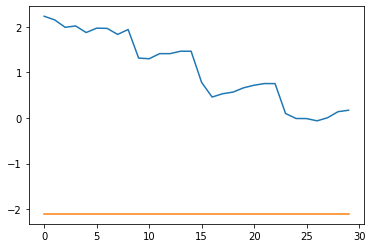

In [44]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

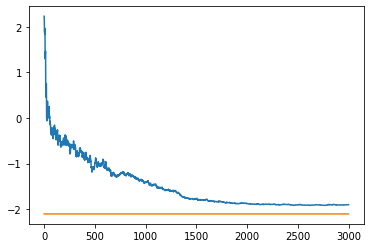

In [47]:
import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)

In [48]:
import pickle

file_to_store = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [49]:
import pickle

file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_beta_"+str(beta)+"_gamma_"+str(gamma)+"_t_"+str(t)+"_u_"+str(u)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

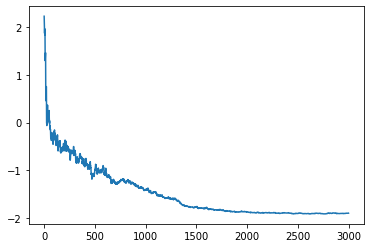

In [50]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [52]:
loaded_object[2999]

{'E': -1.9005966776860888,
 'c': 0.17818483720414563,
 'a': 0.00999489275991702,
 'phi': array([[[ 1.96135021,  0.45803927,  1.53040719],
         [ 0.41669491,  0.49751698,  2.09021889]],
 
        [[-0.52042737, -0.64829507, -1.38946491],
         [ 0.23867139, -0.21958143, -1.33713549]],
 
        [[ 1.84132272,  1.34325256,  1.73068599],
         [-0.03338387, -1.04463051,  1.65816025]],
 
        [[-0.08180085, -0.37499933, -1.14632707],
         [ 0.53881194,  1.31006537, -1.96000376]],
 
        [[-2.28953133,  0.26493331, -1.66391977],
         [-0.17407234, -0.14442224,  0.81450071]],
 
        [[-0.3286396 , -0.3584209 , -1.13263477],
         [ 0.02925443, -0.11548781,  0.02899981]]]),
 'Delta': array([[[ 1.,  1.,  1.],
         [-1.,  1.,  1.]],
 
        [[ 1.,  1., -1.],
         [-1., -1., -1.]],
 
        [[-1.,  1., -1.],
         [ 1.,  1.,  1.]],
 
        [[ 1., -1.,  1.],
         [-1., -1., -1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

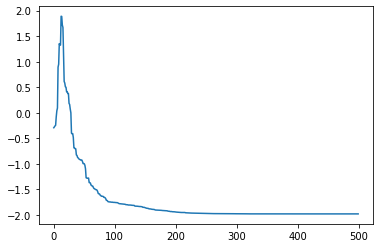

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'